In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline

%config InlineBackend.figure_format = 'retina'


In [5]:
train = pd.read_csv('allstate-claims-severity/train.csv') 
test = pd.read_csv('allstate-claims-severity/test.csv') 

## 观察数据 看看数据是啥样

In [6]:
train.shape

(188318, 132)

In [48]:
train

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,A,B,A,A,A,A,A,A,B,...,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,1198.62
188314,587624,A,A,A,A,A,B,A,A,A,...,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,1108.34
188315,587630,A,B,A,A,A,A,A,B,B,...,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,5762.64
188316,587632,A,B,A,A,A,A,A,A,B,...,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,1562.87


In [7]:
print('First 20 columns:',list(train.columns[:20]))
print('Last 20 columns:',list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


    观察得到：一共有object类型属性116个，float64属性15个，int64属性1个，其中id是int64，loss赔偿是float64

In [8]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


    可以看到此数据已经被缩放，均值基本喂0.5
    数据已经进行了预处理，我们拿到的特征数据。

## 查看缺失值
    大多情况，我们都需要对数据进行缺失值处理。

In [9]:
pd.isnull(train).values.any()
#False 表示没有缺失值

False

## 连续值与离散值。数据特征观察

In [10]:
train.info()

#类型以及数量：float64(15), int64(1), object(116

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [44]:
cat_features = list(train.select_dtypes(include=['object']))
print('离散特征Categorical: {} features'.format(len(cat_features)))

离散特征Categorical: 116 features


In [45]:
cont_features = [cont for cont in list(train.select_dtypes(include=['float64','int64'])) if cont not in ['loss','id']]
print('连续特征Continuous: {} features'.format(len(cont_features)))

连续特征Continuous: 14 features


In [46]:
id_col = list(train.select_dtypes(include=['int64']))
print('A column of int64:{}'.format(id_col))

A column of int64:['id']


## 类别值中属性的个数

In [18]:
#统计类别属性中不同类别的个数
cat_uniques=[]
for cat in cat_features:    
    cat_uniques.append(len(train[cat].unique())) 
uniq_values_in_categories = pd.DataFrame.from_items([('cat_name',cat_features),('unique_values',cat_uniques)])

uniq_values_in_categories.head()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """


,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


Text(7, 71, 'Binary features')

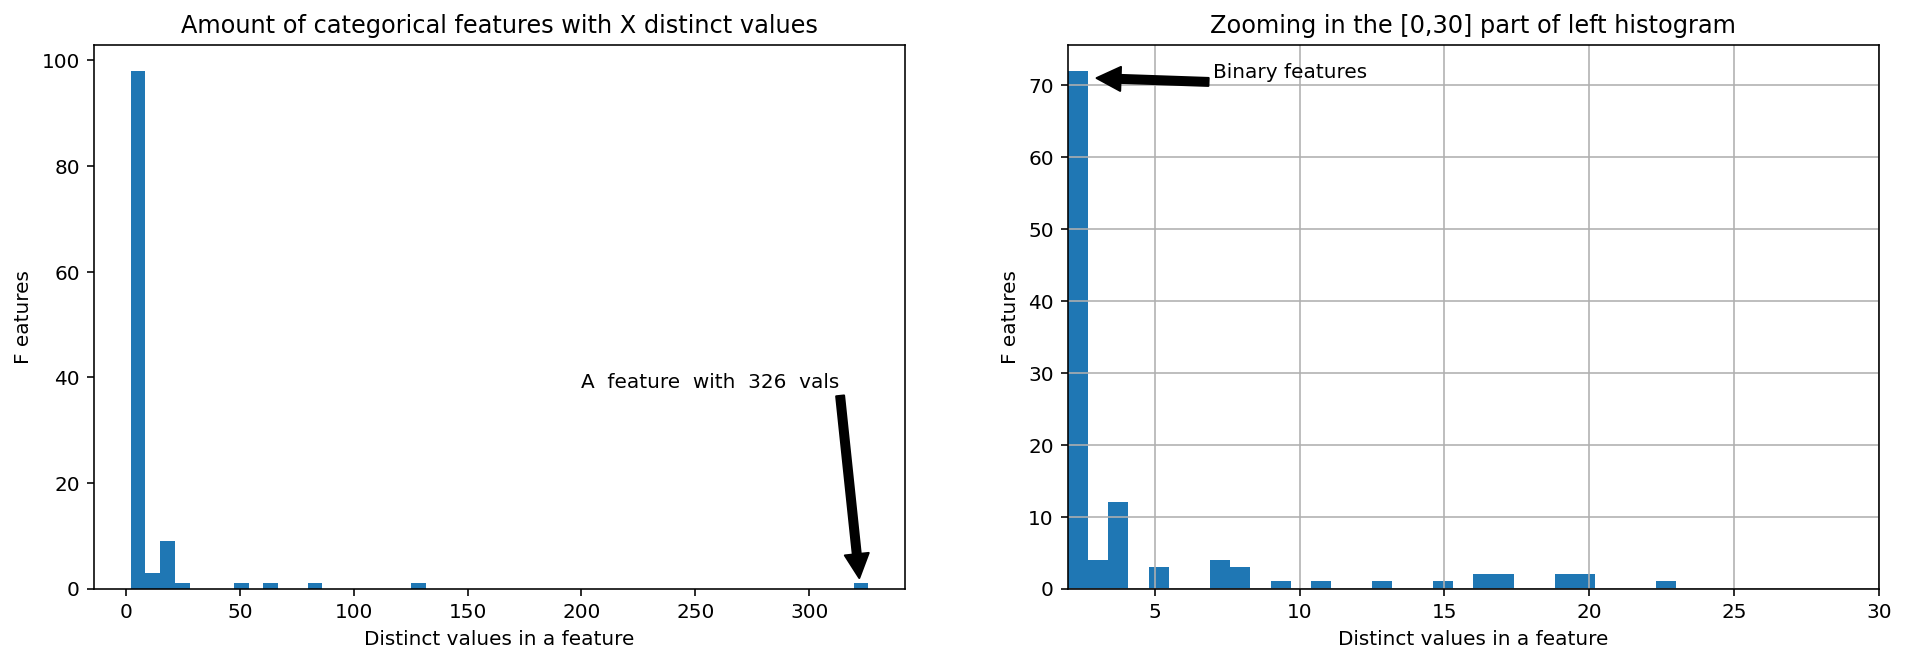

In [23]:
fig,(ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')#离散特征值分布情况
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('F eatures')
ax1.annotate('A  feature  with  326  vals', xy=(322, 2), xytext=(200,  38),arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('F eatures')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values<=30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))


    正如我们所看到的，大部分的分类特征（72/116）是二值的，绝大多数特征（88/116）有四个值，其中有一个具有326个值的特征（一天的数量？）。
    
    
## 赔偿值

No handles with labels found to put in legend.


train['id']个数: 188318


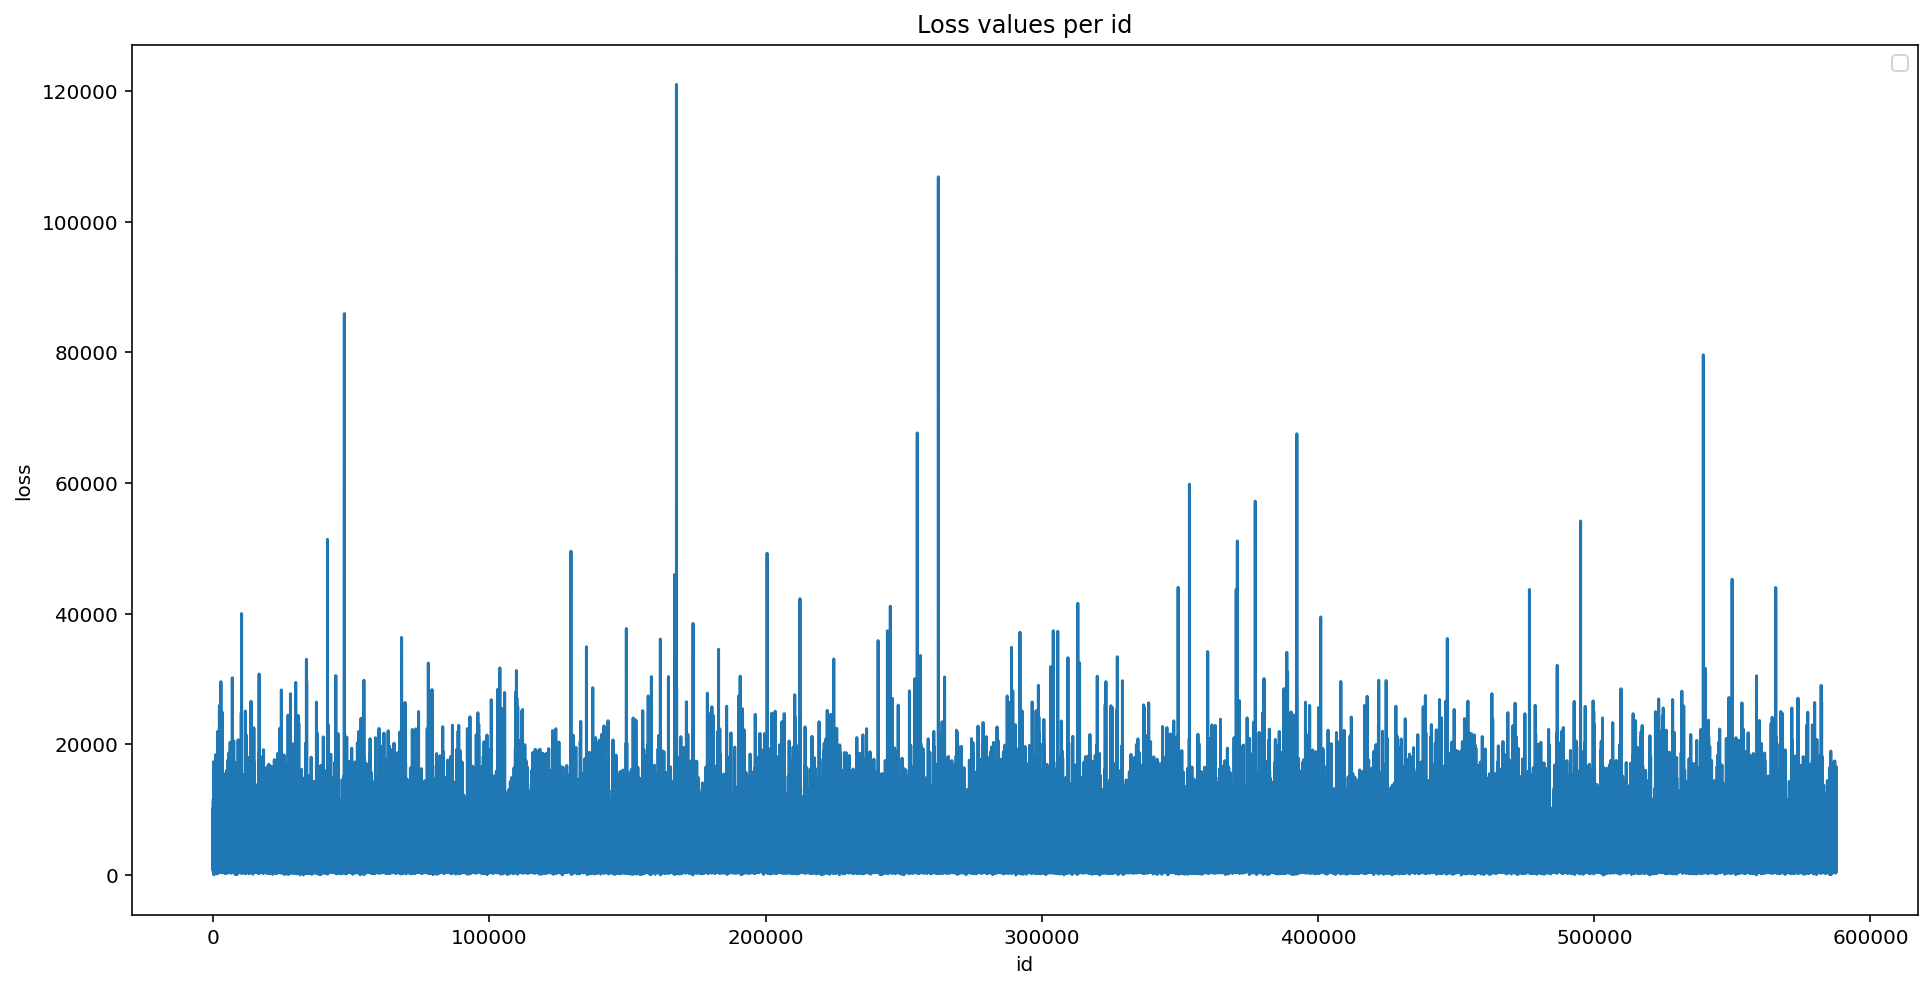

In [32]:
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
print('train[\'id\']个数:',len(train['id']))
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

    损失值有几个显著的峰值，表示严重事故。这样的数据分布，使得这个功能非常扭曲导致回归表现不佳。
 基本上，偏度 度量了实值随机变量的均值分布的不对称性，下面让我们来计算一下loss的偏度：

In [33]:
#scipy.stats 统计指标。

stats.mstats.skew(train['loss']).data

array(3.79492815)

    #偏度值比1大，说明数据是倾斜的。不利于数据建模。
    
    我们利用对数变换np.log，使倾斜降低。

In [35]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

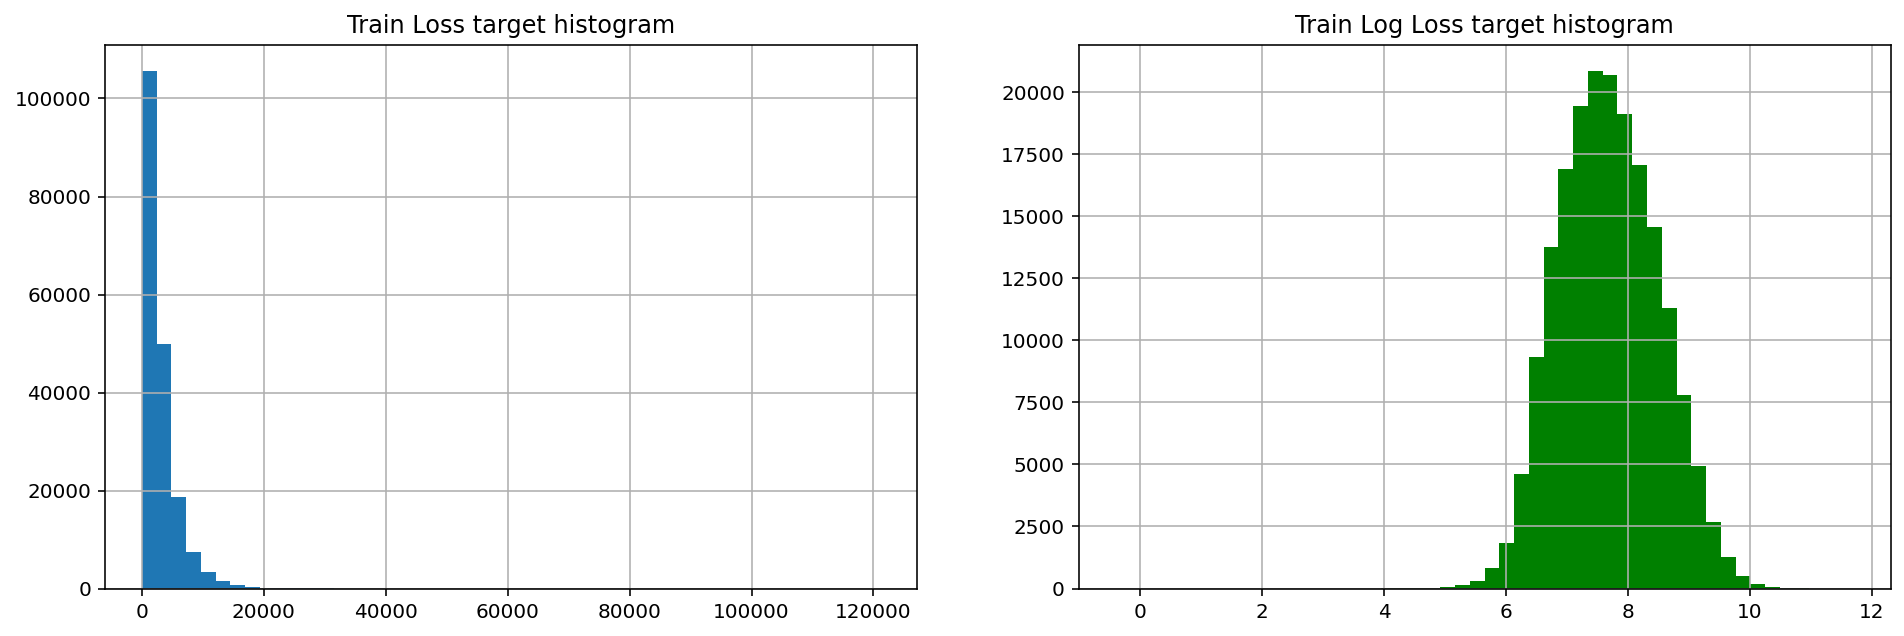

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title("Train Log Loss target histogram")
ax2.grid(True)
plt.show()


    数据loss对数化之后，是我们喜欢的分布类型。
## 连续值特征

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013CDBE37208>,
      dtype=object)

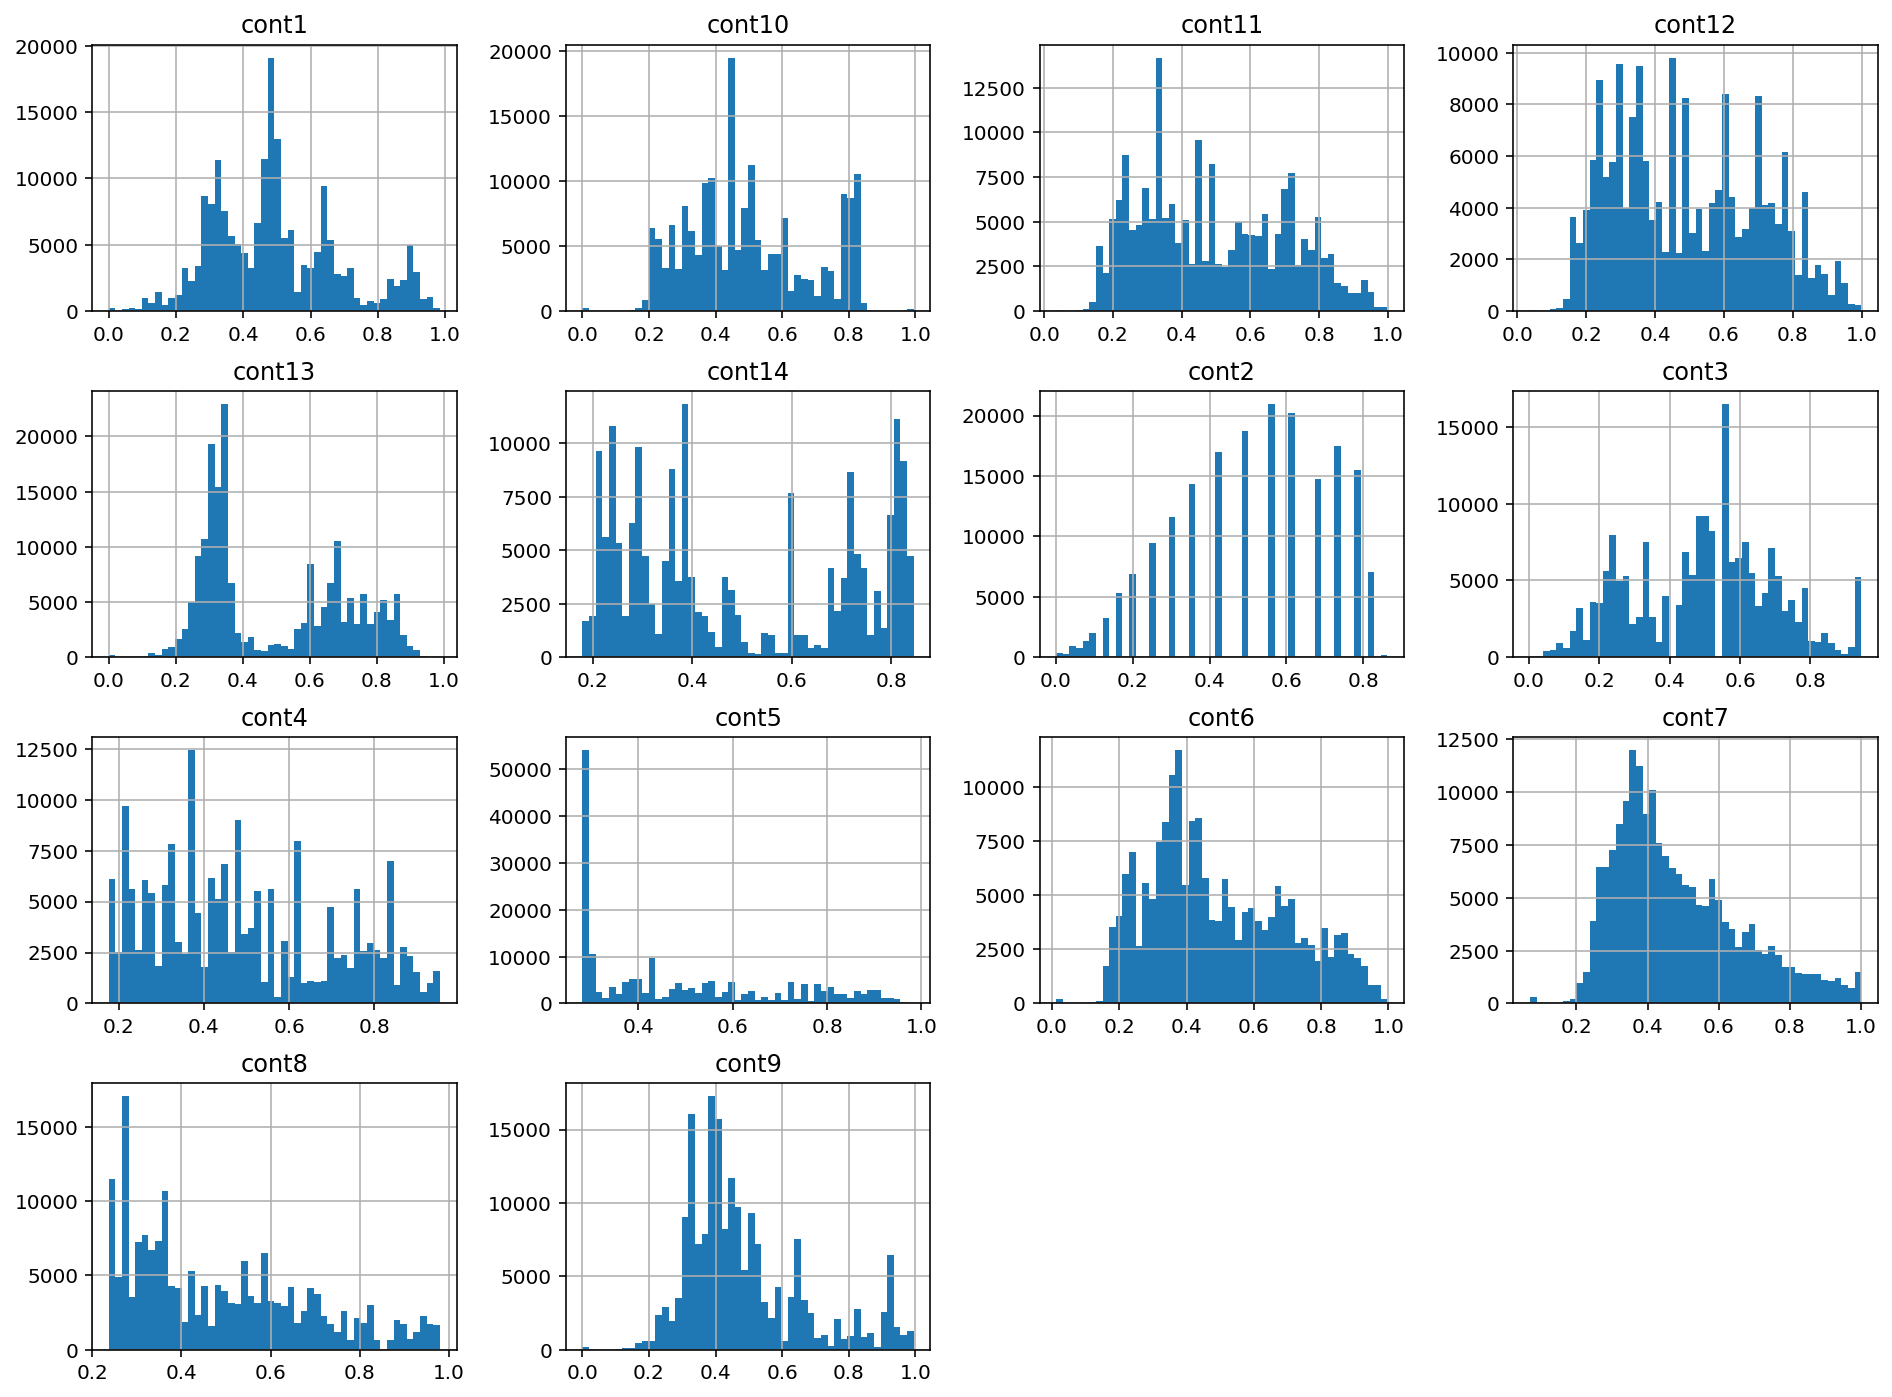

In [51]:
train[cont_features].hist(bins=50,figsize=(16,12))

## 特征之间的相关性

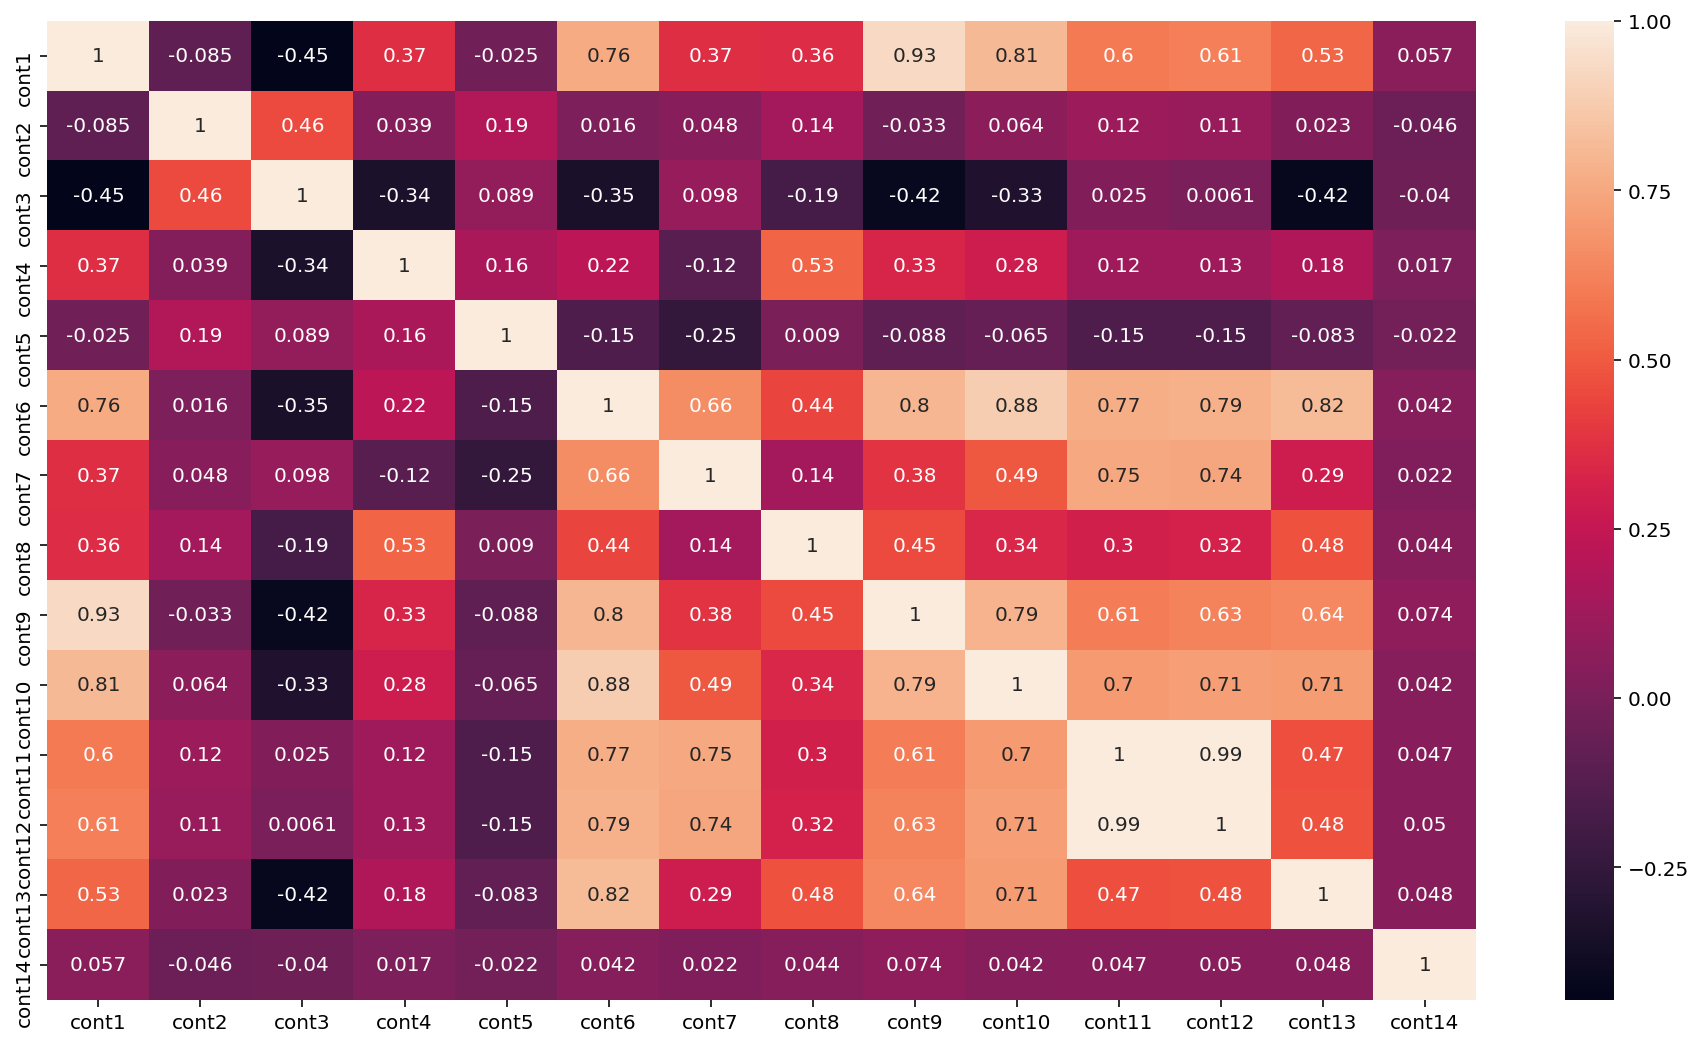

In [49]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat,annot=True)